<a href="https://colab.research.google.com/github/Aatti13/Applied-Machine-Learning-Python-/blob/main/RLAutomated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRL for Automated Trading and Sentiment Analysis

### Team Members:
- Aattreya K.S (22BCE0078)
- Ansh Rajendra Desai (22BCE2332)
- Atharva Harishchandra Gharge (22BEC0593)
- Atul Kumar (22BEC0610)

## Installing Dependencies

In [ ]:
!pip install yfinance transformers stable-baselines3 ta gymnasium


## Importing Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from transformers import pipeline
from ta.momentum import RSIIndicator
from ta.trend import MACD
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gym import spaces
import matplotlib.pyplot as plt

## Downloading Data for RELIANCE.NS

We shall be analysing the RELIANCE Nifty50 Stock and trying to train our model based on this stock

In [ ]:
ticker = 'RELIANCE.NS'
df = yf.download(ticker, start='2018-01-01', end='2024-01-01')
df.reset_index(inplace=True)
df.to_csv("RELIANCE_NS_processed.csv", index=False)


[*********************100%***********************]  1 of 1 completed


## Initial Display of Dataset

The Dataset initially contains the following columns:
- Date
- Close
- High
- Low
- Open
- Volume

In [ ]:
df = pd.read_csv("RELIANCE_NS_processed.csv").iloc[1:]
df.head()

,Date,Close,High,Low,Open,Volume
1,2018-01-01,413.1142883300781,418.99482168215275,412.0925700618405,418.99482168215275,9453202
2,2018-01-02,413.75,417.56442290278204,411.59304260709763,414.59008484319037,9499419
3,2018-01-03,415.407470703125,420.4933578661986,414.612794203002,420.03924401784866,13507800
4,2018-01-04,417.9049987792969,418.58615440854237,415.81615384977414,416.92868884619475,9008932
5,2018-01-05,419.2445983886719,420.9020640413194,417.882317368616,418.586177213428,7441284


## Close Price Over Time

Here using matplotlib we can see the changes in the closing price of RELIANCE.NS

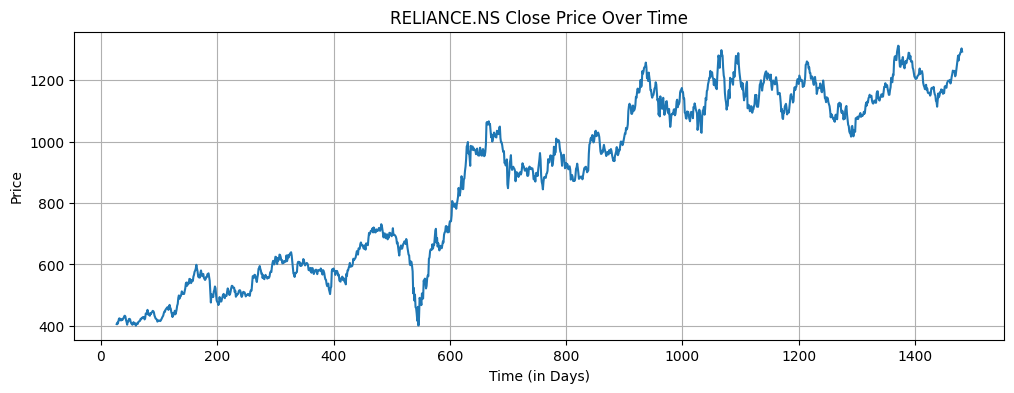

In [ ]:
df['Close'].plot(title='RELIANCE.NS Close Price Over Time', figsize=(12, 4))
plt.xlabel('Time (in Days)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

RSI-Relative strength Index
MACD-Moving or Average Convergence Divergence

In [ ]:
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Ensure Close column is a 1D Series and has no NaNs before calculating
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(subset=['Close'], inplace=True)

# Calculate RSI
rsi_indicator = RSIIndicator(close=df['Close'], window=14)
df['rsi'] = rsi_indicator.rsi()

# Calculate MACD
macd_indicator = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['macd'] = macd_indicator.macd()

# Drop NaNs from indicators
df.dropna(subset=['rsi', 'macd'], inplace=True)


## Assigning News Headers

Since we do not have access to any paid news APIs which are the more reliable ones generally, we shall randomly assign news snippets to the dataset

We have classified news into 3 catrgories:
  1. Positive
  2. Neutral
  3. Negative

In [ ]:
import random

positive_news = [
    "Company reports record-breaking quarterly profits",
    "Strong demand boosts revenue forecasts",
    "Analysts upgrade stock to 'Buy'",
    "CEO confirms aggressive growth plans",
    "New partnership expected to drive innovation"
]

neutral_news = [
    "Company to hold annual general meeting next week",
    "No major changes reported in Q2 financials",
    "Minor restructuring of management announced",
    "Company maintains its dividend policy",
    "Market stays cautious amid global cues"
]

negative_news = [
    "Company misses earnings expectations",
    "Regulatory challenges ahead for expansion",
    "Downgrade issued by top analyst firm",
    "Profit margins shrink due to rising costs",
    "Stock plunges after weak quarterly results"
]

# Mix and assign random news for each row
def generate_random_news():
    return random.choice(positive_news + neutral_news + negative_news)

df['News'] = [generate_random_news() for _ in range(len(df))]

def sentiment_score(news_item):
    if news_item in positive_news:
        return 1
    elif news_item in neutral_news:
        return 0
    elif news_item in negative_news:
        return -1
    else:
        return None

def sentiment_label(news_item):
    if news_item in positive_news:
        return "Positive"
    elif news_item in neutral_news:
        return "Neutral"
    elif news_item in negative_news:
        return "Negative"
    else:
        return "Unknown"

df['SentimentScore'] = df['News'].apply(sentiment_score)
df['Sentiment'] = df['News'].apply(sentiment_label)
df.head()

,Date,Close,High,Low,Open,Volume,rsi,macd,News,SentimentScore,Sentiment
26,2018-02-06,405.099487,407.7786712090015,395.5180515094405,398.24264376911646,24062503,34.851741,-0.741926,Company to hold annual general meeting next week,0,Neutral
27,2018-02-07,406.143890,411.13896079522164,404.1458622151145,409.84479241660233,15532284,35.963732,-2.005458,Regulatory challenges ahead for expansion,-1,Negative
28,2018-02-08,410.752991,413.52299141600304,405.21301964861726,407.73327438041315,13825894,40.768616,-2.604873,Stock plunges after weak quarterly results,-1,Negative
29,2018-02-09,407.710571,409.5950484075345,402.3294991362824,403.69181046459227,11580639,38.704176,-3.287515,Stock plunges after weak quarterly results,-1,Negative
30,2018-02-12,415.725342,416.9513976931257,409.6177361804419,410.0491458651018,11877059,46.403763,-3.145529,Downgrade issued by top analyst firm,-1,Negative


## Candlestick Pattern for RELIANCE.NS

Candlestick chart of RELIANCE.NS stock using Plotly with open, high, low, close prices.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])
fig.update_layout(title='Candlestick Chart - RELIANCE.NS')
fig.show()


## FinBERT Sentiment

Using FinBERT we have seen the sentiment of the stock over time

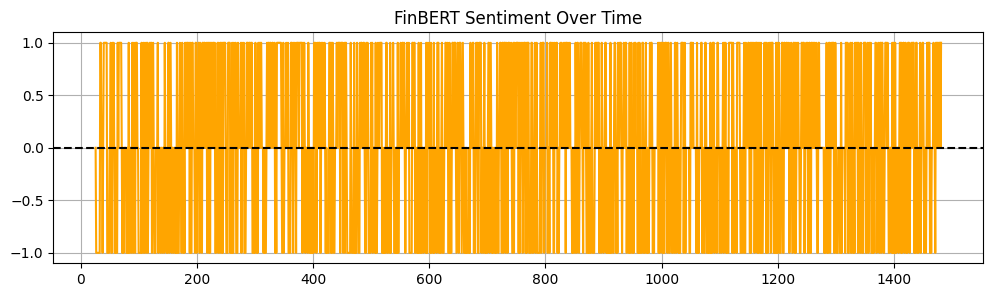

In [ ]:
df['SentimentScore'].plot(title='FinBERT Sentiment Over Time', figsize=(12, 3), color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()


## Sentiment vs Cost Price Over Time

The following is a combined graph for better reference

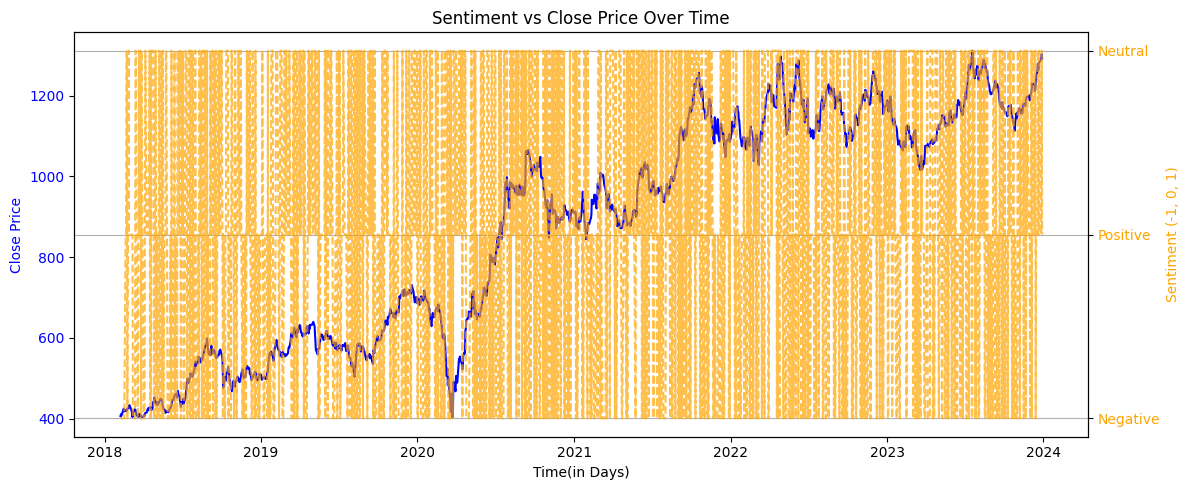

In [ ]:
import matplotlib.pyplot as plt

# Optional: convert date column if needed
df['Date'] = pd.to_datetime(df['Date'])

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot stock Close price
ax1.plot(df['Date'], df['Close'], color='blue', label='Close Price')
ax1.set_xlabel('Time(in Days)')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for sentiment
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Sentiment'], color='orange', label='Sentiment', linestyle='--', alpha=0.7)
ax2.set_ylabel('Sentiment (-1, 0, 1)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and grid
plt.title('Sentiment vs Close Price Over Time')
fig.tight_layout()
plt.grid(True)
plt.show()

---


## Calculations post RSI and MACD

Calculating percentage returns and log of close price, drops NaNs, and sets features including RSI, MACD, and sentiment score.

In [ ]:
df['returns'] = df['Close'].pct_change()
df['log_close'] = np.log(df['Close'])
df.dropna(inplace=True)
features = ['log_close', 'rsi', 'macd', 'SentimentScore', 'returns']

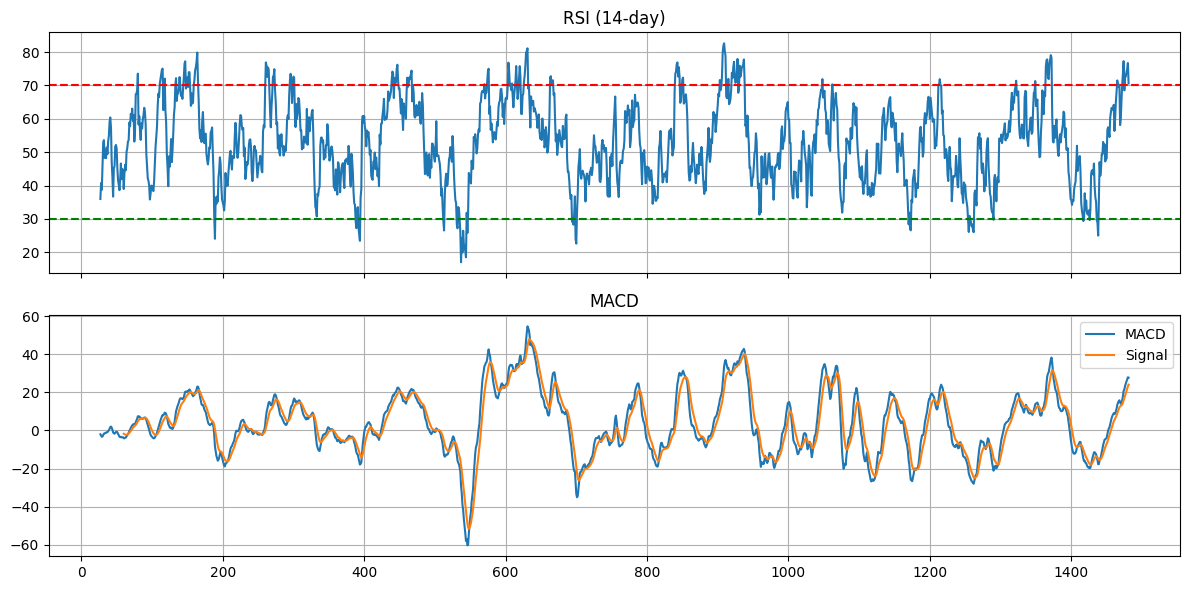

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot RSI
df['rsi'].plot(ax=ax[0], title='RSI (14-day)')
ax[0].axhline(70, color='red', linestyle='--')
ax[0].axhline(30, color='green', linestyle='--')
ax[0].grid(True)

# Plot MACD
df['macd'].plot(ax=ax[1], label='MACD')
df['macd_signal'] = MACD(df['Close']).macd_signal()
df['macd_signal'].plot(ax=ax[1], label='Signal')
ax[1].legend()
ax[1].set_title('MACD')
ax[1].grid(True)

plt.tight_layout()
plt.show()


## Creating the Trading Environment Class

The Trading Environment is creaed and the we define

### States:
  -
  -
  -

### Actions
  - Buy
  - Hold
  - Sell

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index()
        self.current_step = 0
        self.action_space = spaces.Discrete(3)  # 3 possible actions: Buy(0), Hold(1), Sell(2)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.shares_held = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        return self._get_obs(), {}

    def _get_obs(self):
        # Return the observation for the current step, make sure the feature names are correct
        return self.df.loc[self.current_step, features].values.astype(np.float32)

    def step(self, action):
        price = self.df.loc[self.current_step, 'Close']

        if action == 0:  # Buy
            self.shares_held += self.balance // price
            self.balance -= self.shares_held * price
        elif action == 2:  # Sell
            self.balance += self.shares_held * price
            self.shares_held = 0

        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False  # Optional: Can be set to True based on conditions, like max time steps

        next_obs = self._get_obs()
        total_asset = self.balance + self.shares_held * price
        reward = total_asset - self.initial_balance

        return next_obs, reward, terminated, truncated, {}

    def act(self):
        if self.current_step == 0:
            return 1  # Hold on first step
        current_price = self.df.loc[self.current_step, 'Close']
        prev_price = self.df.loc[self.current_step - 1, 'Close']
        if current_price < prev_price:
            return 0  # Buy when price drops
        elif current_price > prev_price:
            return 2  # Sell when price rises
        else:
            return 1  # Hold


## Training Stabe-Baseline3 Model

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap the environment
env = DummyVecEnv([lambda: TradingEnv(df)])

# Train the model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("ppo_trading_model")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 674  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 561          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 1.241162e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 1.73e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31e+10     |
|    n_updates            | 10           |
|    policy_gradient_loss | -5.06e-05    |
|    value_loss           | 2.61e+10     |
------------------------------------------

In [ ]:
# Inside the simulate_trained_model_single_stock function
def simulate_trained_model_single_stock(model, env):
    obs= env.reset()  # Reset environment to initial state
    portfolio_values = []  # Track portfolio value over time

    # Ensure the portfolio value calculation is correct
    total_asset = env.envs[0].balance + env.envs[0].shares_held * env.envs[0].df.loc[env.envs[0].current_step, 'Close']
    portfolio_values.append(total_asset)

    while True:
        action, _states = model.predict(obs)

        next_obs, reward, terminated, truncated = env.step(action)

        current_price = env.envs[0].df.loc[env.envs[0].current_step, 'Close']
        total_asset = env.envs[0].balance + env.envs[0].shares_held * current_price
        portfolio_values.append(total_asset)

        if terminated or truncated:
            break

        obs = next_obs

    return portfolio_values


In [ ]:
def plot_portfolio_values_single_stock(portfolio_values):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values)
    plt.title("Trained PPO Agent - Portfolio Value Over Time (Single Stock)")
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()

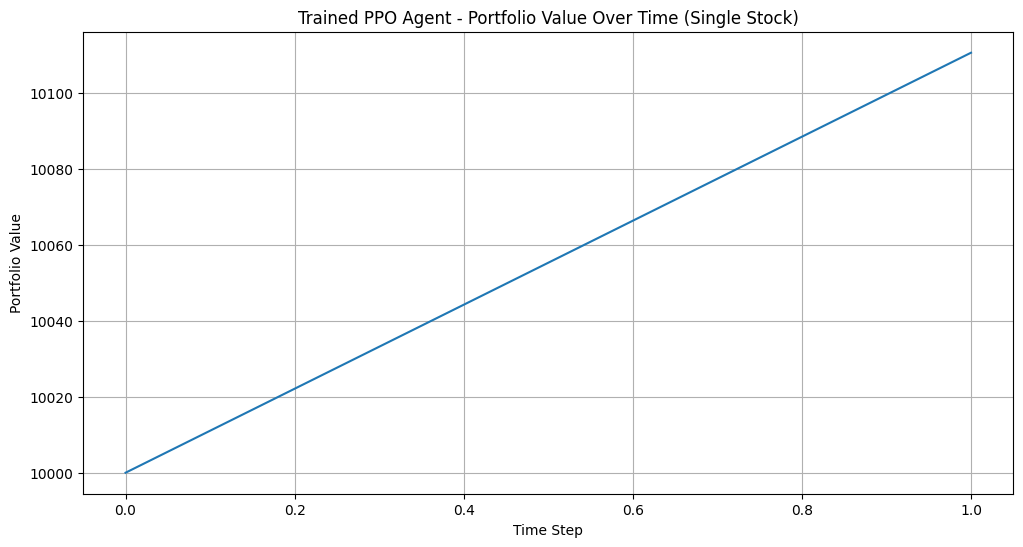

In [ ]:
env = DummyVecEnv([lambda: TradingEnv(df)])  # Your environment setup
model = PPO.load("ppo_trading_model")  # Load the trained model

# Simulate the model for a single stock scenario
portfolio_values = simulate_trained_model_single_stock(model, env)

# Plot the portfolio value over time
plot_portfolio_values_single_stock(portfolio_values)

In [ ]:
def evaluate_performance(portfolio_values):
    """
    Evaluate the performance of a trading agent using portfolio values.

    Args:
        portfolio_values (list or np.array): Portfolio value over time.

    Returns:
        dict: Dictionary with evaluation metrics.
    """
    import numpy as np

    start_value = portfolio_values[0]
    end_value = portfolio_values[-1]
    total_return = (end_value - start_value) / start_value * 100  # in %
    profit = end_value - start_value

    results = {
        "Starting Portfolio Value": round(start_value, 2),
        "Ending Portfolio Value": round(end_value, 2),
        "Total Profit": round(profit, 2),
        "Total Return (%)": round(total_return, 2)
    }

    return results

metrics = evaluate_performance(portfolio_values)
for k, v in metrics.items():
    print(f"{k}: {v}")

Starting Portfolio Value: 10000.0
Ending Portfolio Value: 10110.62
Total Profit: 110.62
Total Return (%): 1.11


In [ ]:
def backtest_trading_strategy(model, env, plot=True):
    import matplotlib.pyplot as plt

    obs = env.reset()  # No info unpacking
    portfolio_values = []
    actions = []
    prices = []
    dates = []

    env_instance = env.envs[0]
    df = env_instance.df

    # Record initial portfolio value
    initial_price = df.loc[env_instance.current_step, 'Close']
    initial_date = df.loc[env_instance.current_step, 'Date'] if 'Date' in df.columns else 0
    initial_asset = env_instance.balance + env_instance.shares_held * initial_price

    portfolio_values.append(initial_asset)
    dates.append(initial_date)

    # Start backtest loop
    while True:
        action, _states = model.predict(obs)
        next_obs, reward, terminated, truncated = env.step(action)  # info ignored

        current_step = env_instance.current_step
        current_price = df.loc[current_step, 'Close']
        current_date = df.loc[current_step, 'Date'] if 'Date' in df.columns else current_step
        total_asset = env_instance.balance + env_instance.shares_held * current_price

        portfolio_values.append(total_asset)
        actions.append(action)
        prices.append(current_price)
        dates.append(current_date)

        if terminated or truncated:
            break
        obs = next_obs

    # Evaluate performance
    metrics = evaluate_performance(portfolio_values)

    # Plot if needed
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, portfolio_values, label='Portfolio Value')
        plt.title("Backtest: Portfolio Value Over Time")
        plt.xlabel("Date" if 'Date' in df.columns else "Time Step")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    return {
        "portfolio_values": portfolio_values,
        "actions": actions,
        "prices": prices,
        "dates": dates,
        "metrics": metrics
    }


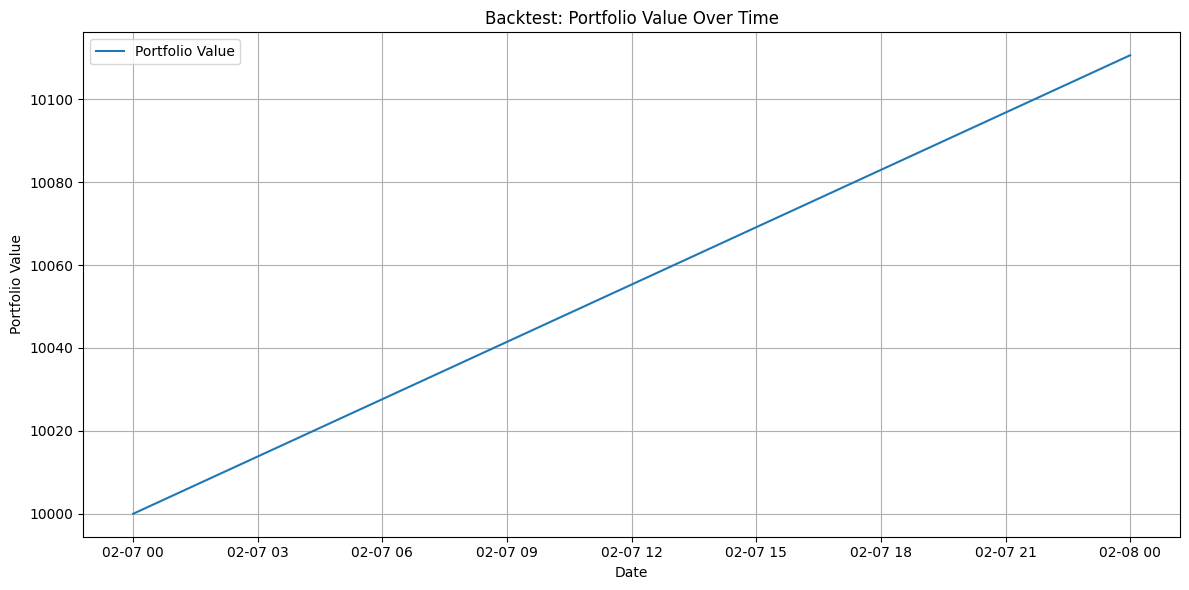

Starting Portfolio Value: 10000.0
Ending Portfolio Value: 10110.62
Total Profit: 110.62
Total Return (%): 1.11


In [ ]:
results = backtest_trading_strategy(model, env)

for k, v in results["metrics"].items():
    print(f"{k}: {v}")
